In [51]:
!pip install pca

In [52]:

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc,classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Load dataset

data_path = "../datasets/wine_development(in).csv"
df = pd.read_csv(data_path)

df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,wine_id
0,5.8,0.31,0.32,4.5,0.024,28.0,94.0,0.98906,3.25,0.52,13.7,7,white,1198
1,6.3,0.13,0.42,1.1,0.043,63.0,146.0,0.99066,3.13,0.72,11.2,7,white,3409
2,8.2,0.30,0.44,12.4,0.043,52.0,154.0,0.99452,3.04,0.33,12.0,6,white,4789
3,9.4,0.17,0.55,1.6,0.049,14.0,94.0,0.99490,3.02,0.61,10.3,6,white,3054
4,5.3,0.30,0.16,4.2,0.029,37.0,100.0,0.99050,3.30,0.36,11.8,8,white,2812


# 1. Data Preperation

## 1.1 Check for outliers

In [53]:
df.drop(columns=["wine_id","quality"], inplace=True)

In [54]:


# Number of missing values per column
missing_values = df.isna().sum()

missing_values


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
color                   0
dtype: int64

In [55]:

numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

numeric_columns


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

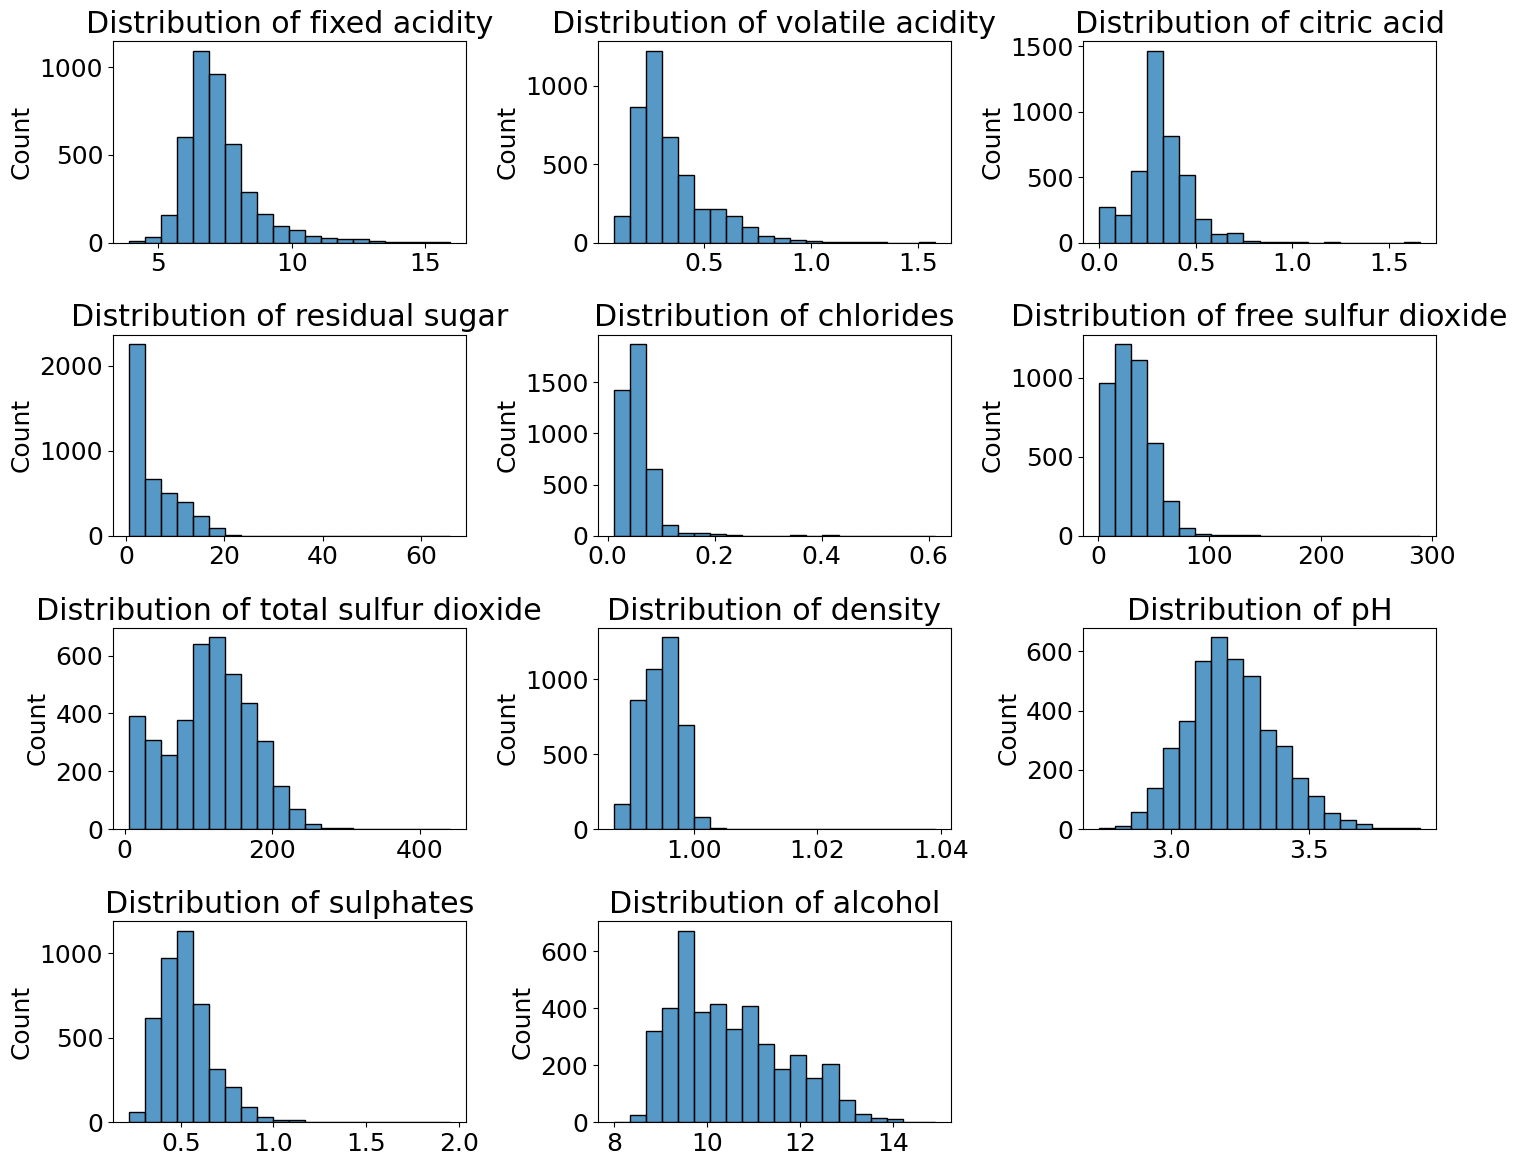

In [56]:
# Calculate grid dimensions
n_cols = 3
n_rows = math.ceil(len(numeric_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten() # Flatten to easily loop over them

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], ax=axes[i], bins=20)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

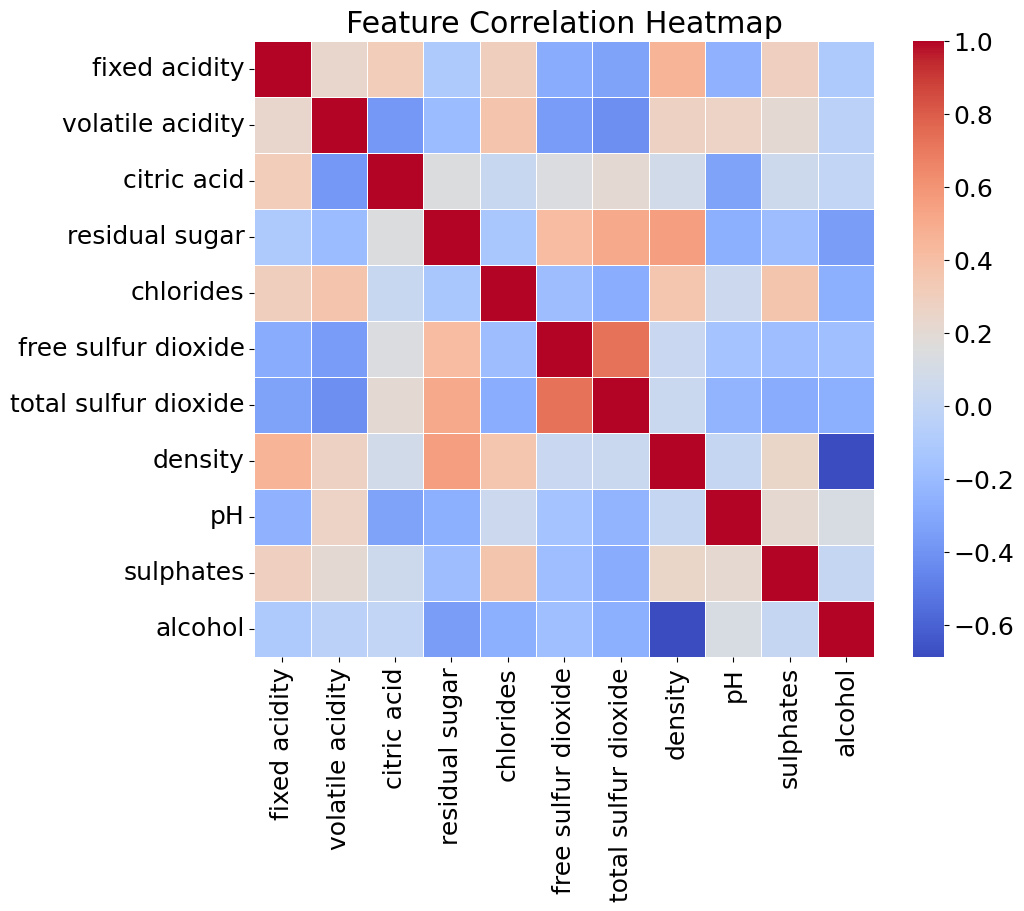

In [57]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_columns].corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


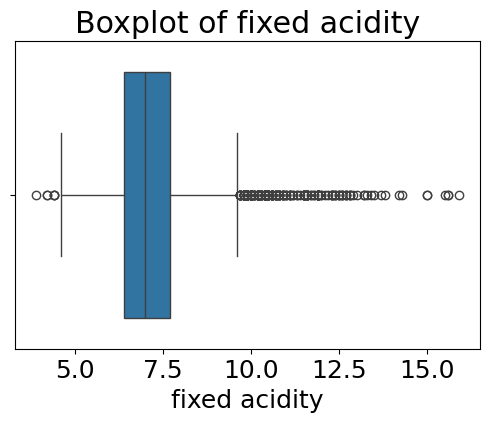

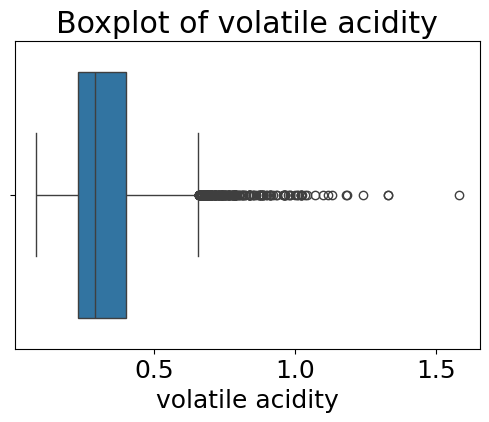

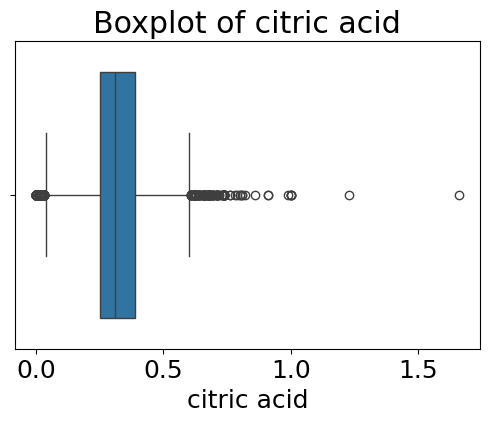

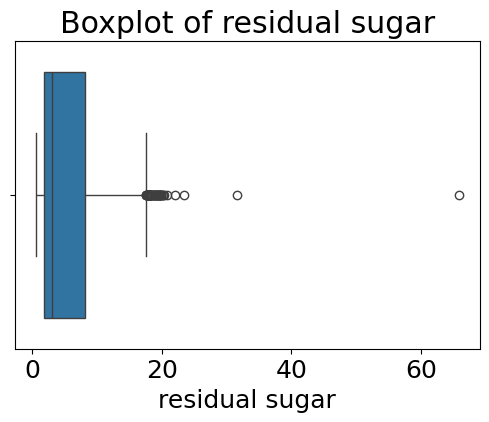

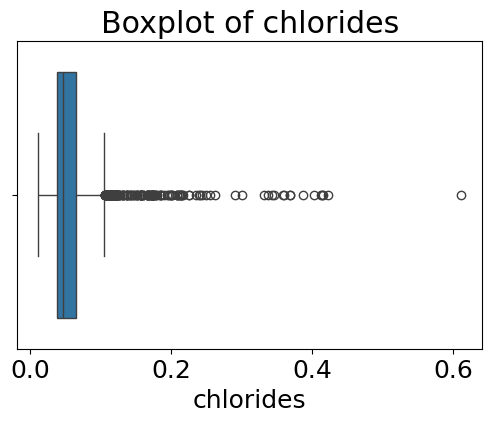

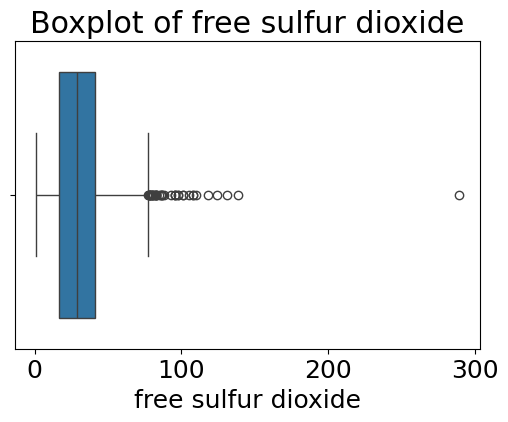

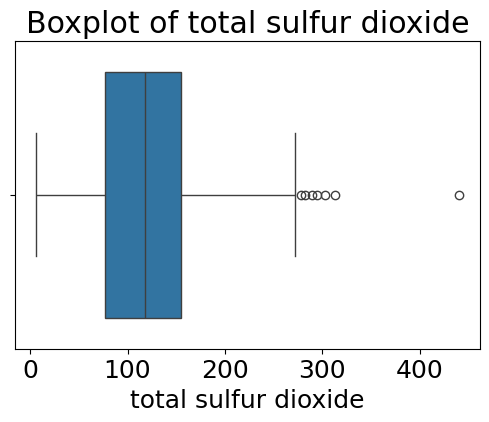

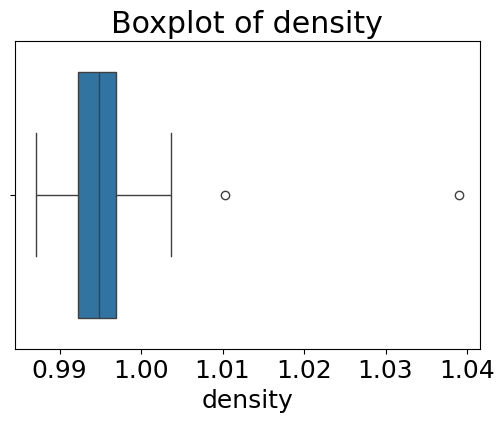

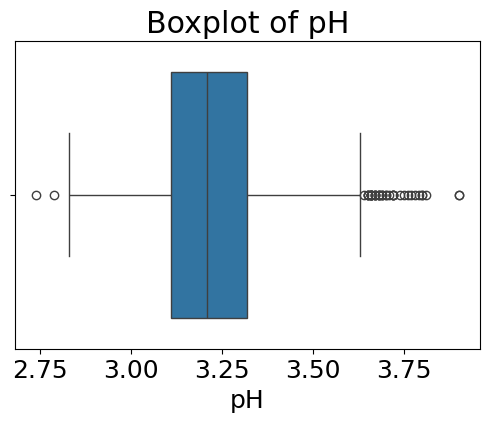

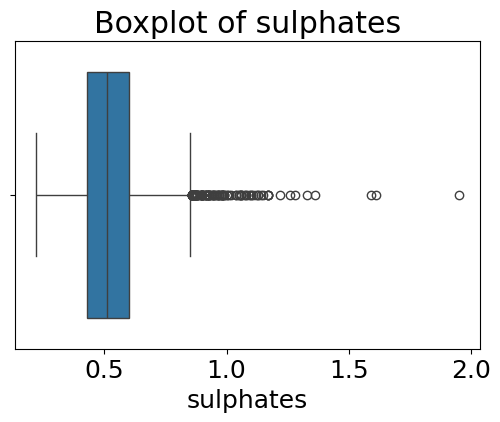

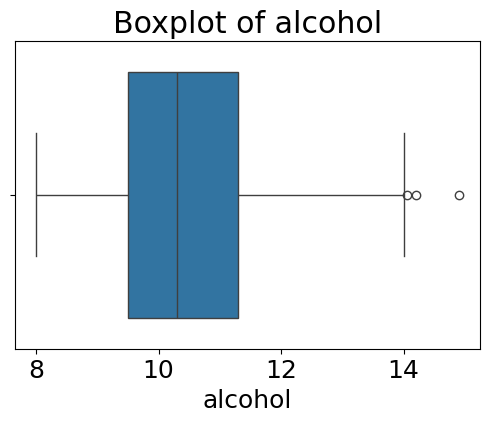

In [58]:

# Boxplots for each numeric variable

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


## 1.2 Check for balance/imbalance of class labels

In [59]:

target = "color"


In [60]:

class_counts = df[target].value_counts()
class_counts


color
white    3134
red      1023
Name: count, dtype: int64

In [61]:

class_percentages = df[target].value_counts(normalize=True) * 100
class_percentages


color
white    75.390907
red      24.609093
Name: proportion, dtype: float64

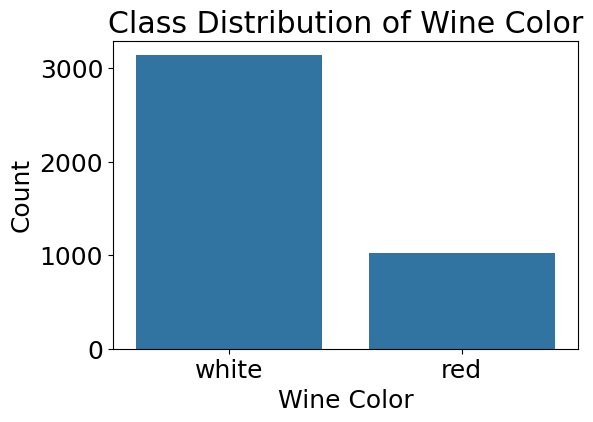

In [62]:

plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=df)
plt.title("Class Distribution of Wine Color")
plt.xlabel("Wine Color")
plt.ylabel("Count")
plt.show()


## 1.3 Split data + Scale data

In [63]:

# Split into features (X) and target (y)

target = "color"

X = df.drop(columns=[target])
y = df[target]

# Train/Test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Keep class proportions
)


# Feature scaling (fit on train, transform both)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)   # Fit ONLY on train
X_test_scaled = scaler.transform(X_test)         # Transform test with same scaler

# Quick check: shapes
X_train_scaled.shape, X_test_scaled.shape


((3325, 11), (832, 11))

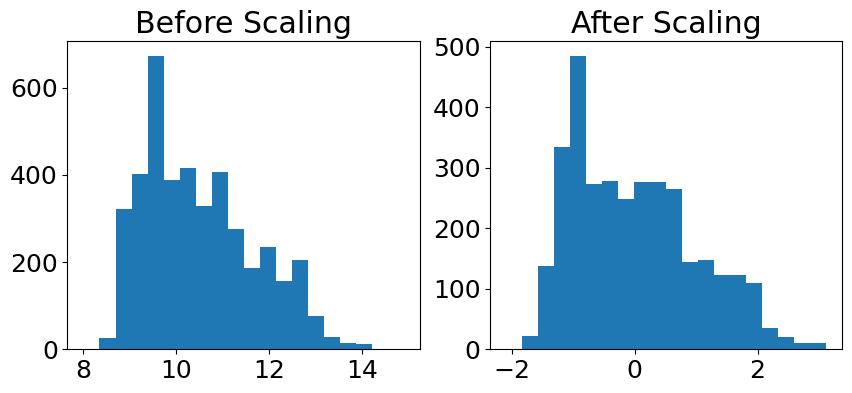

In [64]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(X['alcohol'], bins=20)
plt.title("Before Scaling")

plt.subplot(1,2,2)
plt.hist(X_train_scaled[:, X.columns.get_loc('alcohol')], bins=20)
plt.title("After Scaling")

plt.show()



## 1.4 Use stratified splits to preserver class proportions

In [65]:

# Check class proportions in full / train / test


# Full dataset proportions
full_props = y.value_counts(normalize=True)

# Train set proportions
train_props = y_train.value_counts(normalize=True)

# Test set proportions
test_props = y_test.value_counts(normalize=True)

# Combine into one table
class_distribution_check = pd.DataFrame({
    "full": full_props,
    "train": train_props,
    "test": test_props
}).fillna(0)

# Show as percentages
(class_distribution_check * 100).round(2)


,full,train,test
color,,,
white,75.39,75.4,75.36
red,24.61,24.6,24.64


## SVM with RBF kernel

In [66]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Loop Over Different gamma Values to find better

In [67]:
gamma_values = [0.01, 0.1]
C_values = [0.1, 1]
for gamma in gamma_values:
    for C in C_values:
        svm_rbf = SVC(
            kernel="rbf",
            C=C,
            gamma=gamma,
            random_state=42
        )
    
    svm_rbf.fit(X_train_scaled, y_train)
    y_test_pred = svm_rbf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_test_pred)
    print(f"gamma={gamma}, Test Accuracy: {acc:.4f}")
    print(f"C={C} → Test Accuracy: {acc:.4f}")

gamma=0.01, Test Accuracy: 0.9964
C=1 → Test Accuracy: 0.9964
gamma=0.1, Test Accuracy: 0.9964
C=1 → Test Accuracy: 0.9964


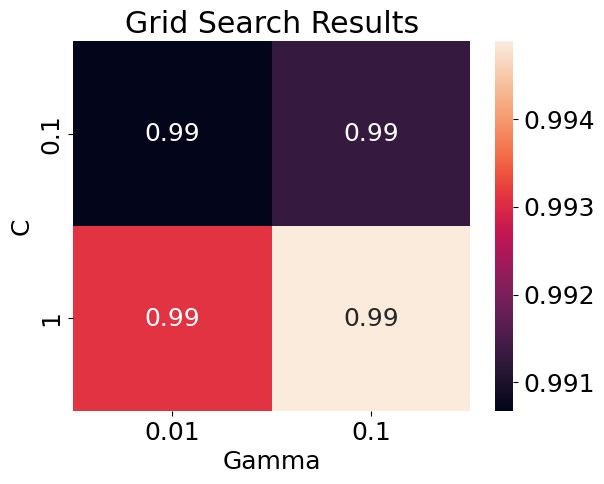

In [68]:
param_grid = {'C':[0.1,1], 'gamma':[0.01,0.1]}
grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

scores = grid.cv_results_['mean_test_score'].reshape(2,2)
sns.heatmap(scores, annot=True, xticklabels=param_grid['gamma'],
            yticklabels=param_grid['C'])
plt.xlabel("Gamma")
plt.ylabel("C")
plt.title("Grid Search Results")
plt.show()


In [69]:
svm_rbf = SVC(
    kernel="rbf",
    C=C,
    gamma=gamma,
    random_state=42
)

svm_rbf.fit(X_train_scaled, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",0.1
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [70]:
print(C)
print (gamma)

1
0.1


In [71]:
y_train_pred = svm_rbf.predict(X_train_scaled)
y_test_pred = svm_rbf.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.9966917293233083
Test Accuracy: 0.9963942307692307

Classification Report (Test Set):
              precision    recall  f1-score   support

         red       1.00      0.99      0.99       205
       white       1.00      1.00      1.00       627

    accuracy                           1.00       832
   macro avg       1.00      0.99      1.00       832
weighted avg       1.00      1.00      1.00       832



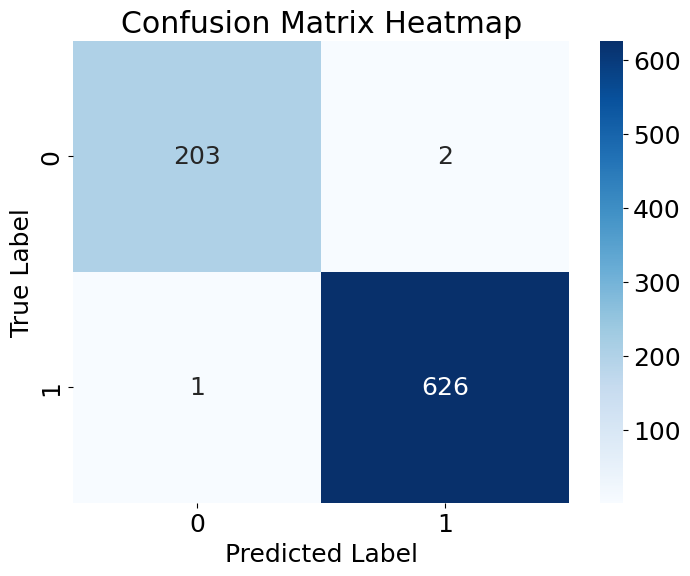

In [72]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

## perform PCA

[19-01-2026 22:06:57] [pca.pca] [INFO] Row labels are auto-completed.
[19-01-2026 22:06:57] [pca.pca] [INFO] The PCA reduction is performed on 11 variables (columns) of the input dataframe.
[19-01-2026 22:06:57] [pca.pca] [INFO] Fit using PCA.
[19-01-2026 22:06:57] [pca.pca] [INFO] Compute loadings and PCs.
[19-01-2026 22:06:57] [pca.pca] [INFO] Compute explained variance.
[19-01-2026 22:06:57] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[19-01-2026 22:06:58] [pca.pca] [INFO] Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[19-01-2026 22:06:58] [pca.pca] [INFO] Outlier detection using SPE/DmodX with n_std=[3]
[19-01-2026 22:06:59] [pca.pca] [WARNING] Parameter <label> is deprecated and will not be supported in future version.
[19-01-2026 22:06:59] [pca.pca] [INFO] Plot PC1 vs PC2 with loadings.
[19-01-2026 22:06:59] [scatterd.scatterd] [INFO] Create scatterplot


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'The top 2 Principal Component(s) explains [50.11%] of the variance.'}, xlabel='PC1 (27.4% expl.var)', ylabel='PC2 (22.6% expl.var)'>)

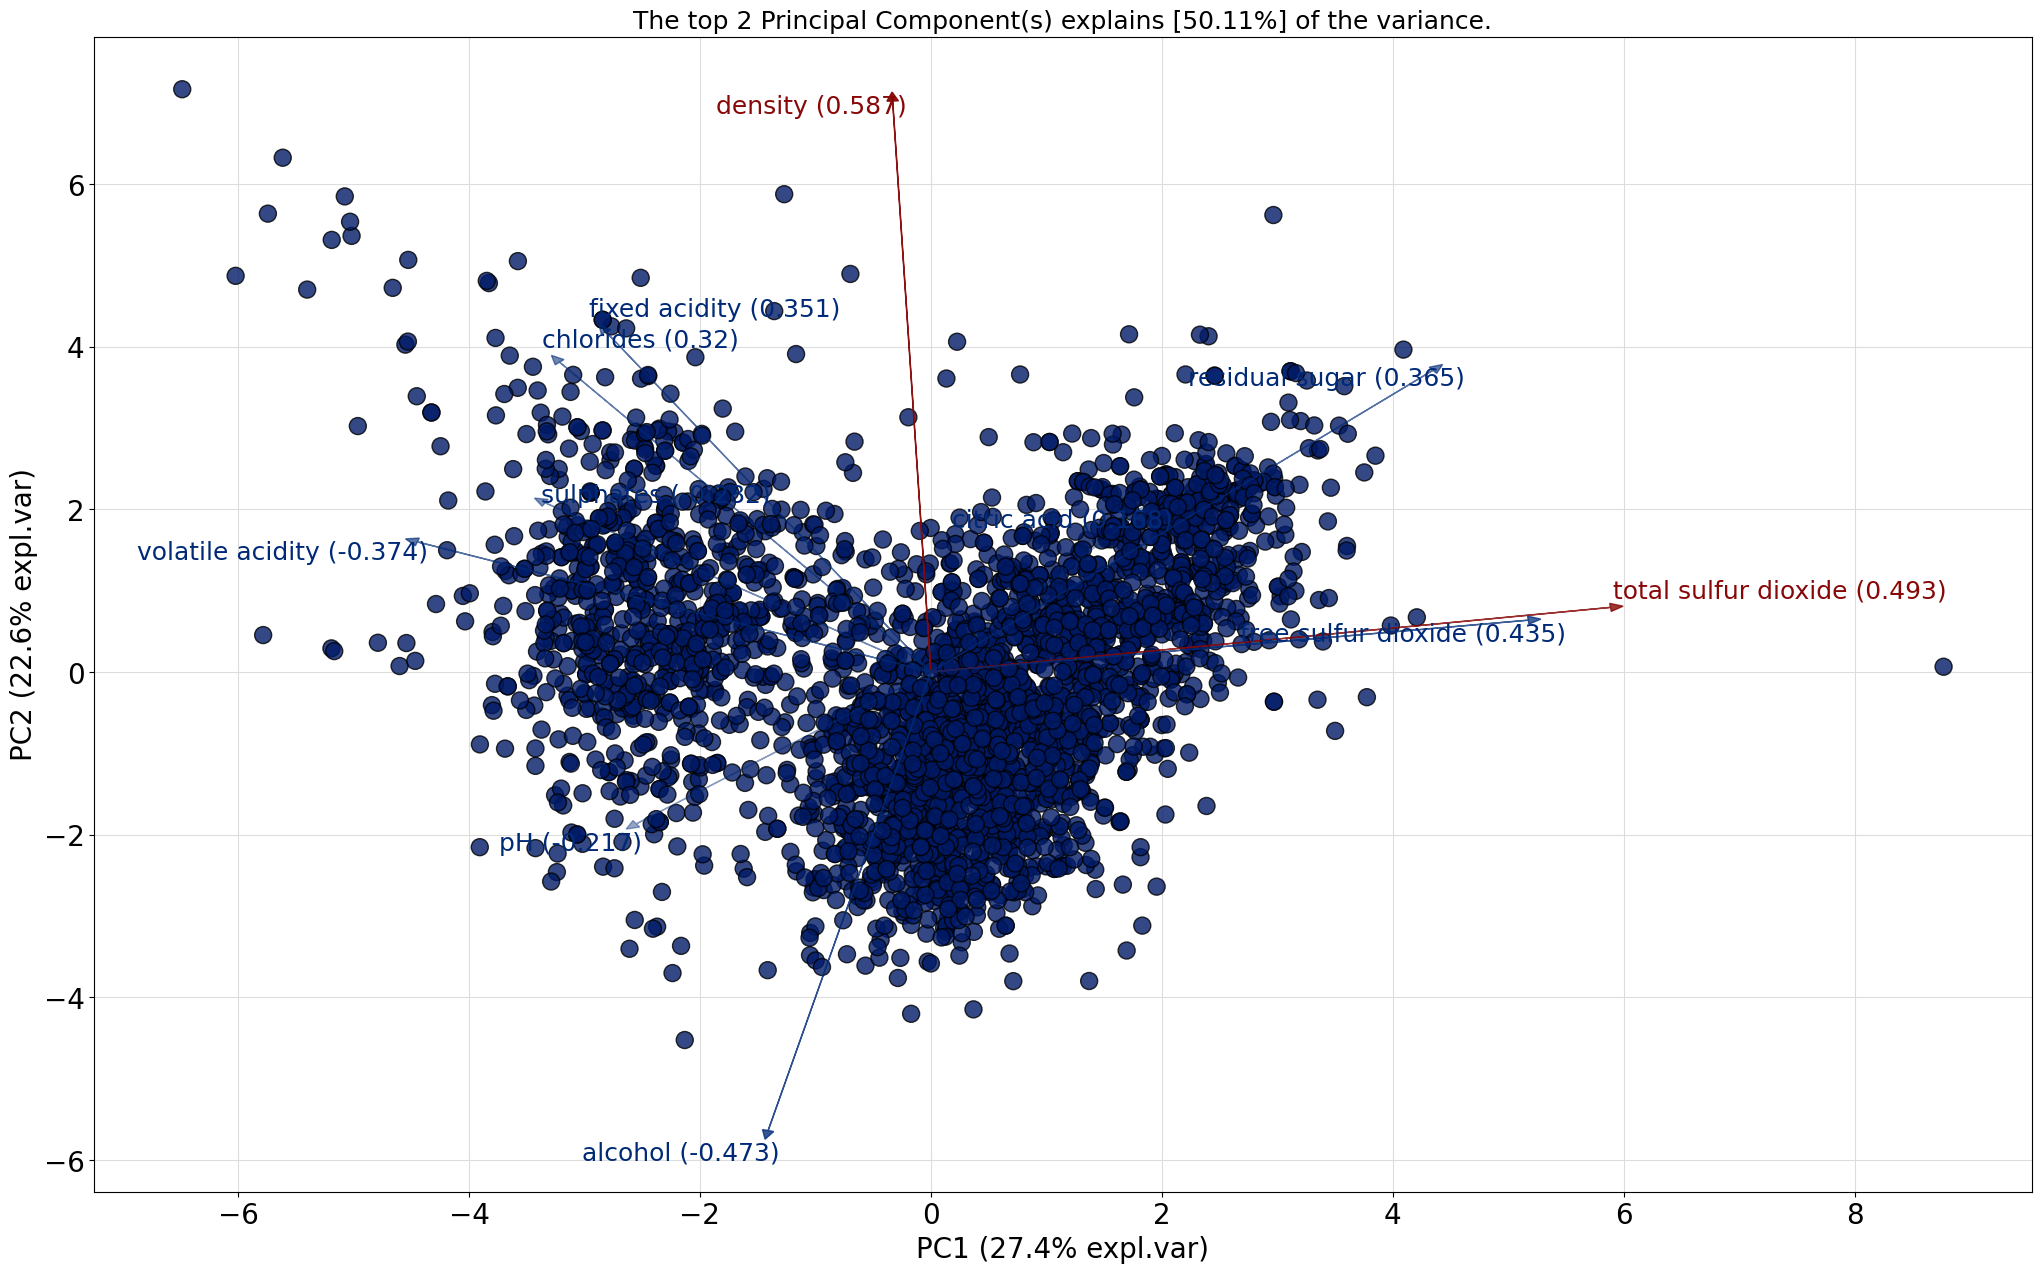

In [73]:
from pca import pca
model = pca(n_components=2) 
labels = X.columns
results = model.fit_transform(X_train_scaled, col_labels=labels)
model.biplot(label=True, legend=True)

[19-01-2026 22:07:00] [pca.pca] [INFO] The PCA reduction is performed on 11 variables (columns) of the input dataframe.
[19-01-2026 22:07:00] [pca.pca] [INFO] Fit using PCA.
[19-01-2026 22:07:00] [pca.pca] [INFO] Compute loadings and PCs.
[19-01-2026 22:07:00] [pca.pca] [INFO] Compute explained variance.
[19-01-2026 22:07:00] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[19-01-2026 22:07:01] [pca.pca] [INFO] Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[19-01-2026 22:07:01] [pca.pca] [INFO] Outlier detection using SPE/DmodX with n_std=[3]
[19-01-2026 22:07:02] [pca.pca] [WARNING] Parameter <label> is deprecated and will not be supported in future version.
[19-01-2026 22:07:02] [pca.pca] [INFO] Plot PC1 vs PC2 with loadings.
[19-01-2026 22:07:02] [scatterd.scatterd] [INFO] Create scatterplot


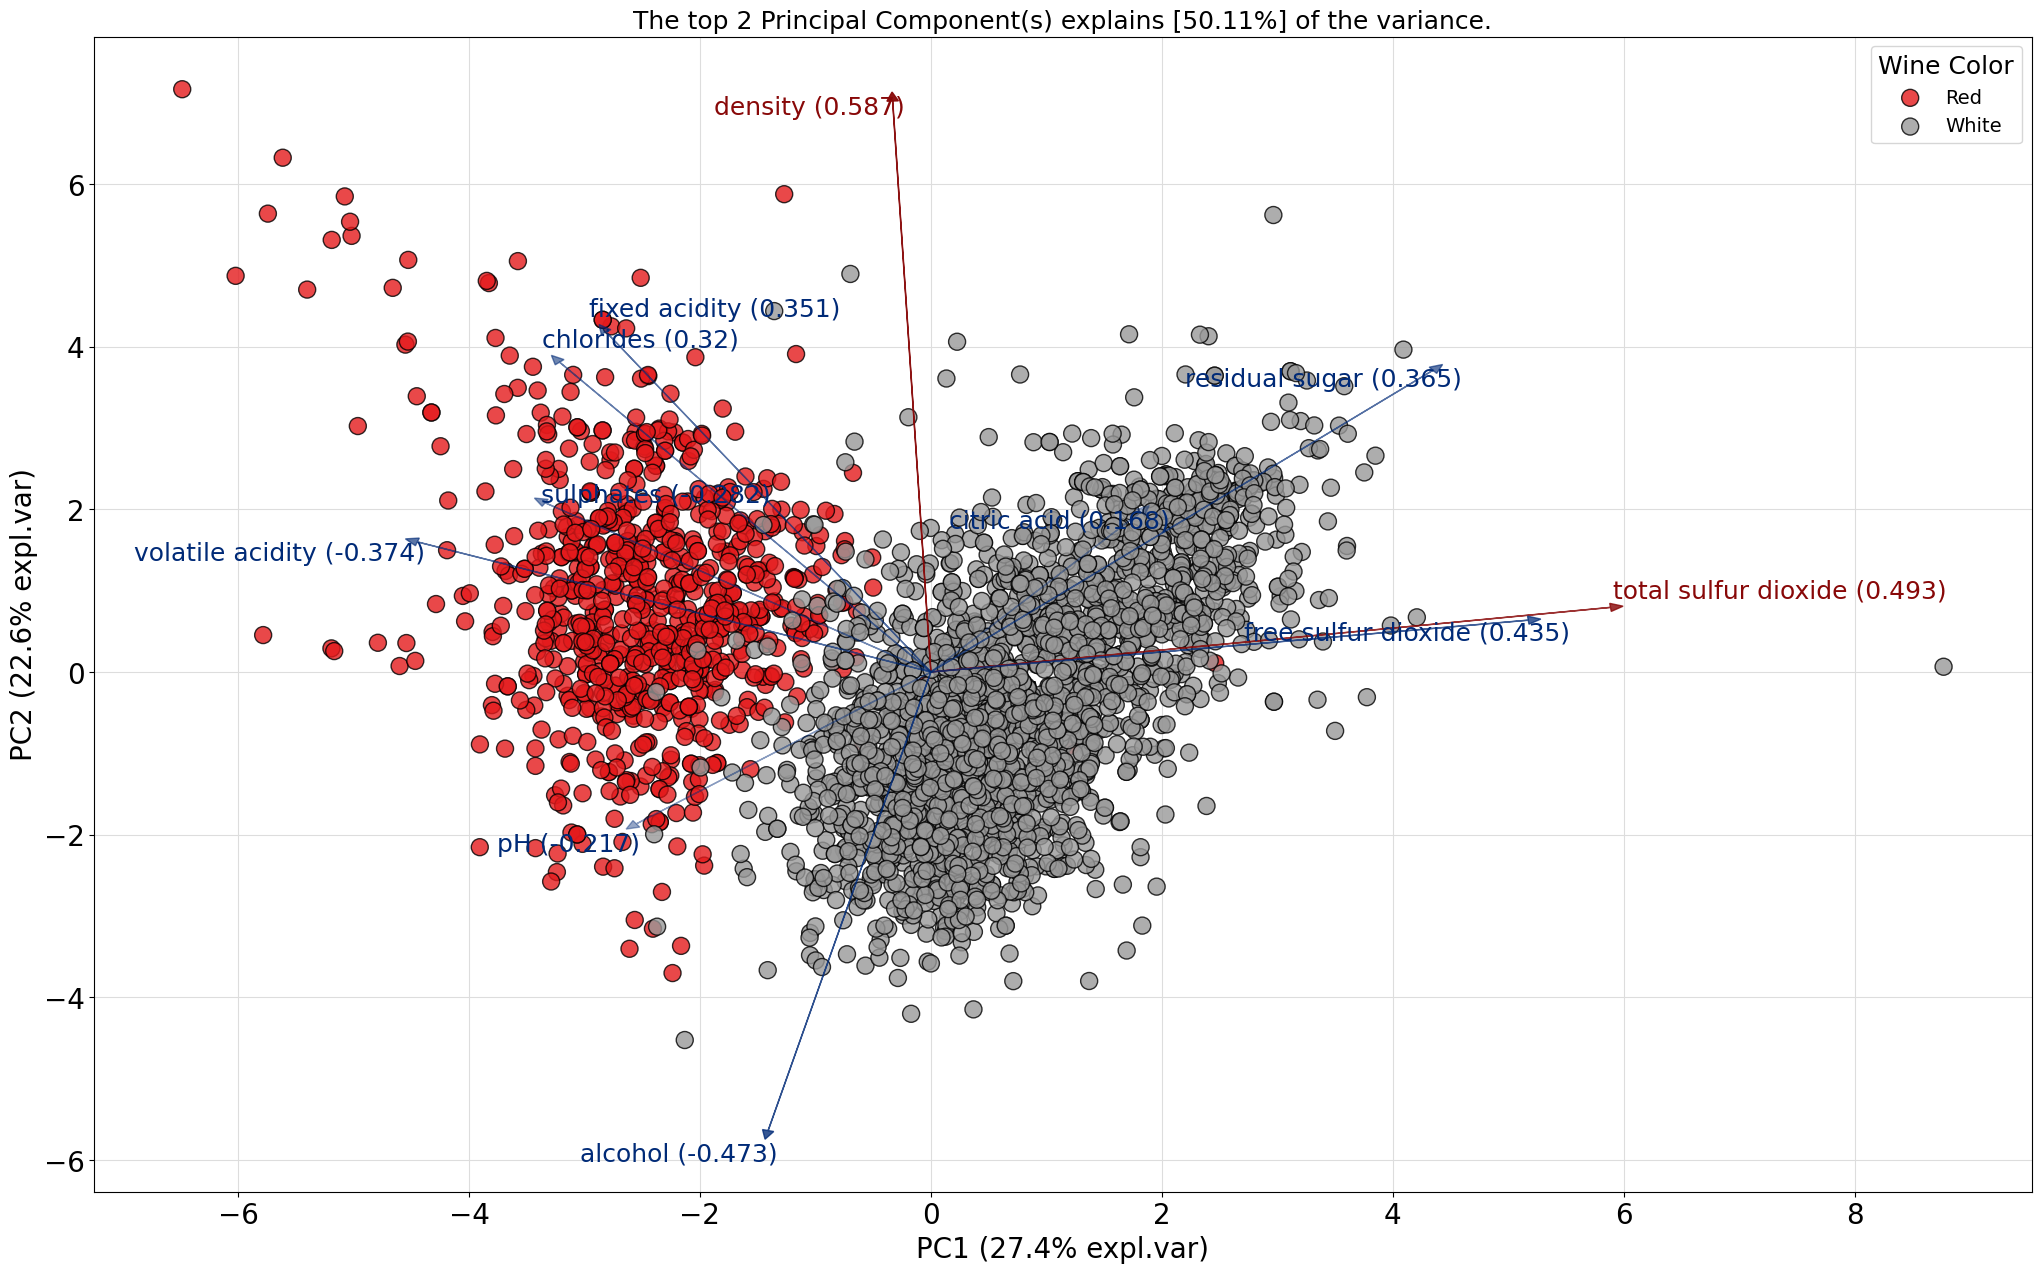

In [74]:
from pca import pca
import matplotlib.pyplot as plt

# 1. Initialize PCA
model = pca(n_components=2)

# 2. Fit and transform 
# Pass 'y' (the wine colors) here so the model knows how to group labels
results = model.fit_transform(X_train_scaled, y_train, col_labels=X.columns)

# 3. Create the biplot
# The library will now use the values in 'y' for the legend automatically
model.biplot(cmap='Set1', label=True, legend=True)

# 4. Optional: Fine-tune the legend if the defaults aren't "Red"/"White"
ax = plt.gca()
legend = ax.get_legend()
if legend:
    legend.set_title("Wine Color")
    # Ensure these indices match your unique classes in y_train
    legend.get_texts()[0].set_text("Red")
    legend.get_texts()[1].set_text("White")

plt.show()

In [75]:
model.results['topfeat']

,PC,feature,loading,type
0,PC1,total sulfur dioxide,0.493153,best
1,PC2,density,0.586501,best
2,PC2,fixed acidity,0.351412,weak
3,PC1,volatile acidity,-0.374369,weak
4,PC2,citric acid,0.168293,weak
5,PC1,residual sugar,0.364577,weak
6,PC2,chlorides,0.320224,weak
7,PC1,free sulfur dioxide,0.434573,weak
8,PC1,pH,-0.217134,weak
9,PC1,sulphates,-0.282474,weak


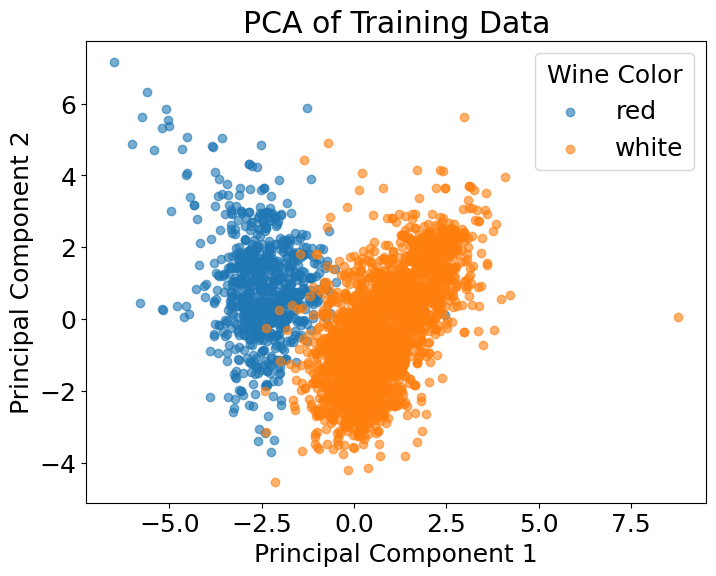

In [76]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
plt.figure(figsize=(8, 6))
for label, color in zip(np.unique(y_train), ['red', 'blue']):
    plt.scatter(
        X_train_pca[y_train == label, 0],
        X_train_pca[y_train == label, 1],
        label=label,
        alpha=0.6
    )
plt.title("PCA of Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Wine Color")
plt.show()

### UNSEEN DATA EVALUATION

In [77]:
X_holdout = pd.read_csv("..\\datasets\\wine_holdout_X(in).csv")
y_holdout = pd.read_csv("..\\datasets\\wine_holdout_y(in).csv")

In [78]:
X_holdout.drop(columns=["wine_id","quality"], inplace=True)

In [79]:
y_holdout = y_holdout["color"]

In [80]:
X_holdout_scaled = scaler.transform(X_holdout)

In [81]:
y_holdout_pred = svm_rbf.predict(X_holdout_scaled)

In [82]:
print("Holdout Accuracy:", accuracy_score(y_holdout, y_holdout_pred))

print("\nHoldout Classification Report:")
print(classification_report(y_holdout, y_holdout_pred))


Holdout Accuracy: 0.9942307692307693

Holdout Classification Report:
              precision    recall  f1-score   support

         red       1.00      0.98      0.99       256
       white       0.99      1.00      1.00       784

    accuracy                           0.99      1040
   macro avg       0.99      0.99      0.99      1040
weighted avg       0.99      0.99      0.99      1040



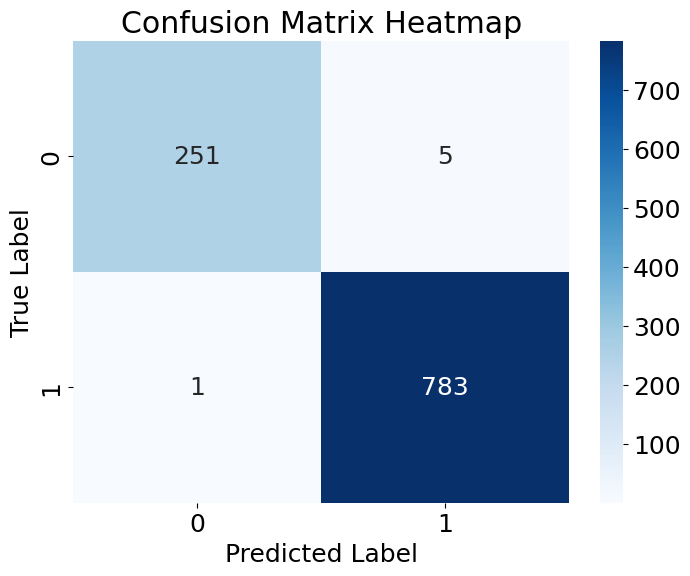

In [83]:
cm = confusion_matrix(y_holdout, y_holdout_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

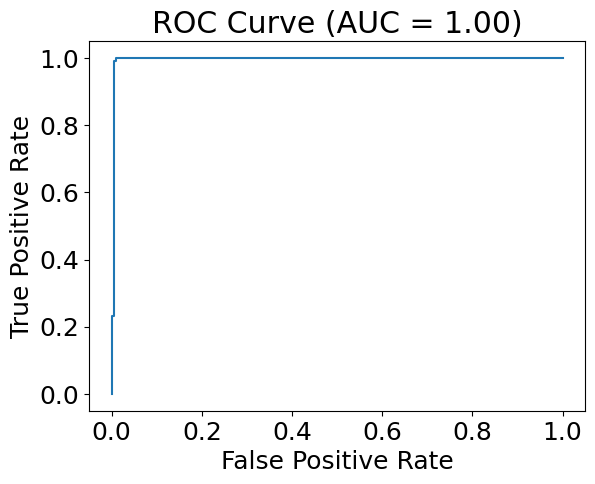

In [84]:
y_prob = svm_rbf.decision_function(X_test_scaled)

fpr, tpr, _ = roc_curve(y_test.map({'red':0,'white':1}), y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


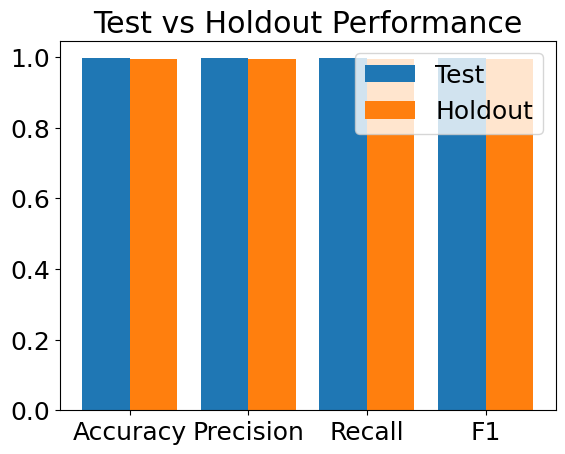

In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate test metrics
acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred, average='weighted')
rec_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Calculate holdout metrics
acc_hold = accuracy_score(y_holdout, y_holdout_pred)
prec_hold = precision_score(y_holdout, y_holdout_pred, average='weighted')
rec_hold = recall_score(y_holdout, y_holdout_pred, average='weighted')
f1_hold = f1_score(y_holdout, y_holdout_pred, average='weighted')

# Calculate train metrics (for completeness)
acc_train = accuracy_score(y_train, y_train_pred)

labels = ['Accuracy', 'Precision', 'Recall', 'F1']
test_scores = [acc_test, prec_test, rec_test, f1_test]
holdout_scores = [acc_hold, prec_hold, rec_hold, f1_hold]

x = range(len(labels))

plt.bar(x, test_scores, width=0.4, label='Test')
plt.bar([i+0.4 for i in x], holdout_scores, width=0.4, label='Holdout')
plt.xticks([i+0.2 for i in x], labels)
plt.legend()
plt.title("Test vs Holdout Performance")
plt.show()


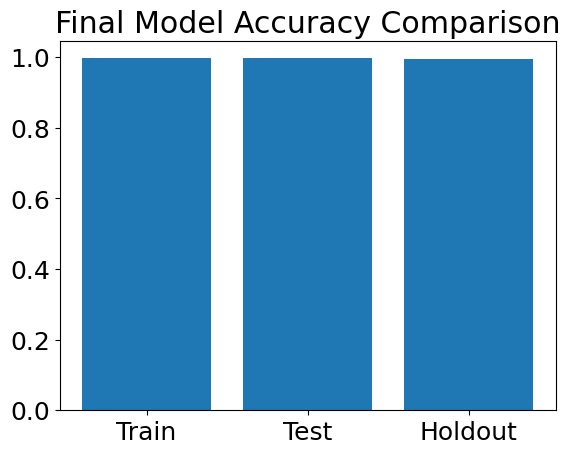

In [86]:
plt.bar(['Train','Test','Holdout'], [acc_train, acc_test, acc_hold])
plt.title("Final Model Accuracy Comparison")
plt.show()
